In [1]:
import tensorflow.keras as keras
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import sys

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Input dataset
Dataset used is celebA : https://www.kaggle.com/jessicali9530/celeba-dataset

(64, 64, 3)
len dataset :  202599


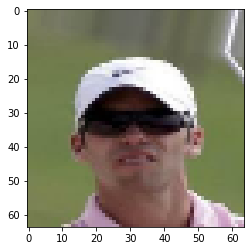

In [3]:
IM_DIM = 64
@tf.function
def im_preprocessing(im_path) :
    im_file = tf.io.read_file(im_path)
    im = tf.io.decode_jpeg(im_file)
    im = tf.image.convert_image_dtype(im, tf.float32)
    #im = tf.image.crop_to_bounding_box(im, 20,0,178,178)
    im = tf.image.resize(im, [IM_DIM, IM_DIM])
    im = tf.image.random_flip_left_right(im)
    return(im)

batch_size = 32
im_patern = "./data/img_align_celeba/img_align_celeba/*.jpg"
files_dataset = tf.data.Dataset.list_files(im_patern)
im_dataset = files_dataset.map(im_preprocessing)
im_dataset_repeated = im_dataset.repeat()
im_dataset_batch = im_dataset_repeated.batch(batch_size)

for x in im_dataset.take(1) :
    print(x.numpy().shape)
    print("len dataset : ", tf.data.experimental.cardinality(im_dataset).numpy())
    plt.imshow(x)
    
batch_gen = iter(im_dataset_batch)

## Making models

In [4]:
DEPTH = 32
LATENT_DEPTH = 512
K_SIZE = 5

In [5]:
def sampling(args):
    mean, logsigma = args
    epsilon = keras.backend.random_normal(shape=keras.backend.shape(mean))
    return mean + tf.exp(logsigma / 2) * epsilon

def encoder():
    input_E = keras.layers.Input(shape=(IM_DIM, IM_DIM, 3))
    
    X = keras.layers.Conv2D(filters=DEPTH*2, kernel_size=K_SIZE, strides=2, padding='same')(input_E)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Conv2D(filters=DEPTH*4, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Conv2D(filters=DEPTH*8, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(LATENT_DEPTH)(X)    
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    mean = keras.layers.Dense(LATENT_DEPTH,activation="tanh")(X)
    logsigma = keras.layers.Dense(LATENT_DEPTH,activation="tanh")(X)
    latent = keras.layers.Lambda(sampling, output_shape=(LATENT_DEPTH,))([mean, logsigma])
    
    kl_loss = 1 + logsigma - keras.backend.square(mean) - keras.backend.exp(logsigma)
    kl_loss = keras.backend.mean(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    return keras.models.Model(input_E, [latent,kl_loss])

def generator():
    input_G = keras.layers.Input(shape=(LATENT_DEPTH,))

    X = keras.layers.Dense(8*8*DEPTH*8)(input_G)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.Reshape((8, 8, DEPTH * 8))(X)
    
    X = keras.layers.Conv2DTranspose(filters=DEPTH*8, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Conv2DTranspose(filters=DEPTH*4, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Conv2DTranspose(filters=DEPTH, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Conv2D(filters=3, kernel_size=K_SIZE, padding='same')(X)
    X = keras.layers.Activation('sigmoid')(X)

    return keras.models.Model(input_G, X)

def discriminator():
    input_D = keras.layers.Input(shape=(IM_DIM, IM_DIM, 3))
    
    X = keras.layers.Conv2D(filters=DEPTH, kernel_size=K_SIZE, strides=2, padding='same')(input_D)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Conv2D(filters=DEPTH*4, kernel_size=K_SIZE, strides=2, padding='same')(input_D)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    X = keras.layers.BatchNormalization()(X)

    X = keras.layers.Conv2D(filters=DEPTH*8, kernel_size=K_SIZE, strides=2, padding='same')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)

    X = keras.layers.Conv2D(filters=DEPTH*8, kernel_size=K_SIZE, padding='same')(X)
    inner_output = keras.layers.Flatten()(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(DEPTH*8)(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha=0.2)(X)
    
    output = keras.layers.Dense(1)(X)    
    
    return keras.models.Model(input_D, [output, inner_output])

## Training

In [6]:
for x in im_dataset_batch.take(1) :
    test_images = x
test_r = tf.random.normal((batch_size, LATENT_DEPTH))

In [7]:
E = encoder()
G = generator()
D = discriminator() 

In [ ]:
lr=0.0001
#lr=0.0001
E_opt = keras.optimizers.Adam(lr=lr)
G_opt = keras.optimizers.Adam(lr=lr)
D_opt = keras.optimizers.Adam(lr=lr)

inner_loss_coef = 1
normal_coef = 0.1
kl_coef = 0.01

@tf.function
def train_step_vaegan(x):
    lattent_r =  tf.random.normal((batch_size, LATENT_DEPTH))
    with tf.GradientTape(persistent=True) as tape :
        lattent,kl_loss = E(x)
        fake = G(lattent)
        dis_fake,dis_inner_fake = D(fake)
        dis_fake_r,_ = D(G(lattent_r))
        dis_true,dis_inner_true = D(x)

        vae_inner = dis_inner_fake-dis_inner_true
        vae_inner = vae_inner*vae_inner
        
        mean,var = tf.nn.moments(E(x)[0], axes=0)
        var_to_one = var - 1
        
        normal_loss = tf.reduce_mean(mean*mean) + tf.reduce_mean(var_to_one*var_to_one)
        
        kl_loss = tf.reduce_mean(kl_loss)
        vae_diff_loss = tf.reduce_mean(vae_inner)
        f_dis_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(dis_fake), dis_fake))
        r_dis_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(dis_fake_r), dis_fake_r))
        t_dis_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(dis_true), dis_true))
        gan_loss = (0.5*t_dis_loss + 0.25*f_dis_loss + 0.25*r_dis_loss)
        vae_loss = tf.reduce_mean(tf.abs(x-fake)) 
        E_loss = vae_diff_loss + kl_coef*kl_loss + normal_coef*normal_loss
        G_loss = inner_loss_coef*vae_diff_loss - gan_loss
        D_loss = gan_loss
    
    E_grad = tape.gradient(E_loss,E.trainable_variables)
    G_grad = tape.gradient(G_loss,G.trainable_variables)
    D_grad = tape.gradient(D_loss,D.trainable_variables)
    del tape
    E_opt.apply_gradients(zip(E_grad, E.trainable_variables))
    G_opt.apply_gradients(zip(G_grad, G.trainable_variables))
    D_opt.apply_gradients(zip(D_grad, D.trainable_variables))

    return [gan_loss, vae_loss, f_dis_loss, r_dis_loss, t_dis_loss, vae_diff_loss, E_loss, D_loss, kl_loss, normal_loss]

step = 0
max_step = 10000000
log_freq,img_log_freq = 10, 100
save_freq,save_number_mult = 1000, 10000

metrics_names = ["gan_loss", "vae_loss", "fake_dis_loss", "r_dis_loss", "t_dis_loss", "vae_inner_loss", "E_loss", "D_loss", "kl_loss", "normal_loss"]
metrics = []
for m in metrics_names :
    metrics.append(tf.keras.metrics.Mean('m', dtype=tf.float32))

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = ('logs/sep_D%dL%d/' % (DEPTH,LATENT_DEPTH)) + current_time 
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
name = ('sep_D%dL%d' % (DEPTH,LATENT_DEPTH))

def save_model() :
    nb = str(step // save_number_mult)
    D.save('saved-models/D_training_' + nb + '.h5')
    G.save('saved-models/G_training_' + nb + '.h5')
    E.save('saved-models/E_training_' + nb + '.h5')

def print_metrics() :
    s = ""
    for name,metric in zip(metrics_names,metrics) :
        s+= " " + name + " " + str(np.around(metric.result().numpy(), 3)) 
    print(f"\rStep : " + str(step) + " " + s, end="", flush=True)
    with train_summary_writer.as_default():
        for name,metric in zip(metrics_names,metrics) :
            tf.summary.scalar(name, metric.result(), step=step)
    for metric in metrics : 
        metric.reset_states()

        
def log_images() :
    with train_summary_writer.as_default():
        lattent,_ = E(test_images)
        fake = G(lattent)
        fake_r = G(test_r)
        tf.summary.image("reconstructed image", fake[:8], step=step, max_outputs=8)
        tf.summary.image("random image", fake_r[:8], step=step, max_outputs=8)
        dis_fake,inner_dis_fake = D(fake)
        dis_fake_r,inner_dis_fake_r = D(fake_r)
        dis_true,inner_dis_true = D(test_images)
        tf.summary.histogram("dis fake", inner_dis_fake, step=step, buckets=20)
        tf.summary.histogram("dis true", inner_dis_true, step=step, buckets=20)
        tf.summary.histogram("dis random", inner_dis_fake_r, step=step, buckets=20)
        tf.summary.histogram("dis lattent", lattent, step=step, buckets=20)
        tf.summary.histogram("dis normal", tf.random.normal((batch_size, LATENT_DEPTH)), step=step, buckets=20)        

for x in batch_gen :
    step += 1
    if not step % log_freq :
        print_metrics()
    if not step % img_log_freq :
        log_images()
    if not step % save_freq :
        save_model()
    
    results = train_step_vaegan(x)
    for metric,result in zip(metrics, results) :
        metric(result)

Step : 14900  gan_loss 0.171 vae_loss 0.182 fake_dis_loss 0.319 r_dis_loss 0.066 t_dis_loss 0.15 vae_inner_loss 0.021 E_loss 0.034 D_loss 0.171 kl_loss 0.16 normal_loss 0.10708